<h2 id="anexoI" style="background-color: #80B8D1 ; color: white; padding: 5px;font-size: 20px;">ANEXO I - DESPLIEGUE DEL MODELO</h2>

Se desarrolló una aplicación con una interfaz web y una API utilizando Flask, que permite a los usuarios obtener predicciones de la vida útil remanente (RUL) para motores. La API ofrece un endpoint /predict_file donde los usuarios pueden cargar un archivo CSV con datos de sensores del motor. Estos datos se preprocesan y luego se introducen en el modelo previamente entrenado para obtener una predicción de la RUL. La predicción se devuelve como respuesta, proporcionando a los usuarios una estimación de la vida útil remanente del motor. Además, la API cuenta con un endpoint /info que brinda detalles sobre el nombre y la versión del modelo.

Es importante destacar que esta aplicación se basa en un modelo previamente entrenado, no se realiza un nuevo entrenamiento del modelo en este contexto, sino que se utiliza el modelo final creado y el cuál fue guardado. A su vez, durante el desarrollo, se estudiaron y diseñaron los pasos necesarios para procesar los datos de entrada, lo que incluyó la utilización de un "scaler" específico para normalizar los datos. Este "scaler" también se guardó para su posterior uso en la aplicación.

A continuación, se presenta el código de la aplicación.

In [ ]:
import pickle
from flask import Flask, request
import numpy as np
import pandas as pd
from flasgger import Swagger
from tensorflow.keras.models import load_model

#INFORMACIÓN GENERAL DEL MODELO
model_name="RUL prediction"
version="Versión 1.0.0"

#CARGA DE MODELO Y SCALER
## 1. Modelo
modelo=load_model("ModeloFinal.h5")

## 2. Scaler
with open("scalers_dict.pkl", "rb") as scaler_file:
    scalers_dict = pickle.load(scaler_file)
    
#Aplicación 
app = Flask(__name__)
swagger=Swagger(app)

#PREDICCIÓN
@app.route("/predict_file",methods=["POST"])
def predict_file():
    """Este servicio devuelve una predicción de la RUL de su motor. 
    ---
    parameters:
    - name: input_file
      in: formData
      type: file
      required: true
    responses:
          200:
            description: OK
    """
    input_data=pd.read_csv(request.files.get("input_file"))
    #Procesamiento de datos: eliminar ruido
    input_data["setting_1"]=input_data["setting_1"].round(decimals=1)
    input_data["setting_2"]=input_data["setting_2"].round(decimals=2)
    input_data["setting_3"]=input_data["setting_3"].astype(float)
    
    #condición operativa
    input_data["condición_op"] = input_data["setting_1"].astype(str) + "_" + \
                             input_data["setting_2"].astype(str) + "_" + \
                             input_data["setting_3"].astype(str)
    input_data.drop(labels=["setting_1","setting_2","setting_3"],axis=1,inplace=True)
    
    #Escalado 
    sensor = ["s_{}".format(i+1) for i in range(0,21)]
    for cond in input_data["condición_op"].unique():
        scaler = scalers_dict[cond]
        filtro = input_data[input_data["condición_op"] == cond]
        input_data.loc[input_data["condición_op"] == cond, sensor] = scaler.transform(filtro[sensor])
        
    #Dummies
    input_data=pd.get_dummies(data=input_data,columns=["condición_op"])
    
    #Eliminar sensores
    sensores_a_eliminar = ["s_1", "s_5", "s_18", "s_19","s_10"]
    input_data=input_data.drop(labels=sensores_a_eliminar,axis=1)
    
    #Convertir a array con las columnas en el orden esperado
    columnas=sorted(input_data.columns)
    input_data=input_data[columnas]
    input_array=input_data.values
    input_array=np.expand_dims(input_array, axis=0)
    
    #Predicción
    prediction=modelo.predict(input_array)
    prediction=prediction[0][0].round(1)
    output= str("La RUL predicha para este motor es: "+str(prediction))
    
    return output

#INFORMACIÓN DEL MODELO
@app.route("/info", methods=["GET"])
def info():
    """Devuelve información del modelo (nombre y versión)
    ---
    responses:
          200:
            description: OK
    """
    result = {}
    result["Nombre"] = model_name
    result["Version"] = version
    return result


if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


### INTERFAZ DE USUARIO
Para acceder a la interfaz de usuario, simplemente se debe ingresar a la dirección proporcionada y agregar "/apidocs" al final (por ejemplo: http://127.0.0.1:5000/apidocs/). 

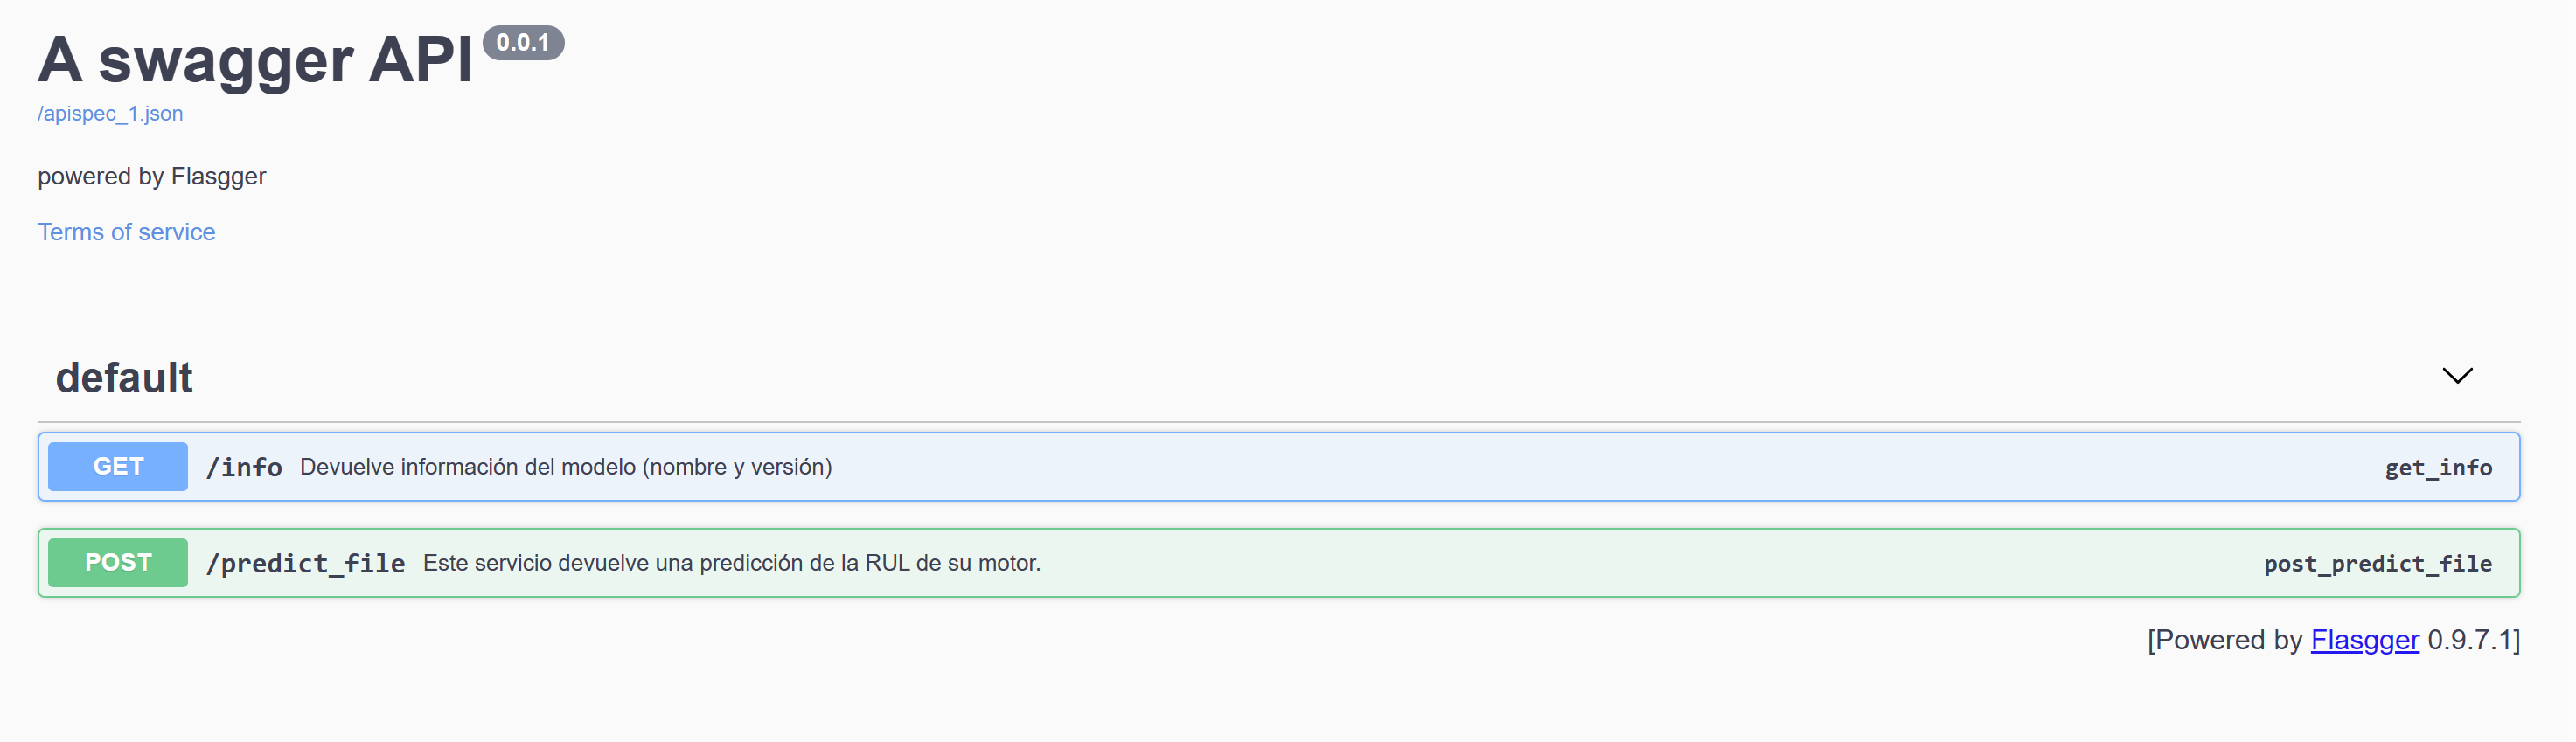

Eso dará acceso a una interfaz interactiva (imagen superior) desde donde los usuarios pueden interactuar con el sistema de la siguiente manera:

**1. Obtener Información del Modelo:**

Utilizando el endpoint */info*, los usuarios pueden obtener información detallada sobre el modelo que se encuentra en el sistema. En particular el nombre y la versión de éste:

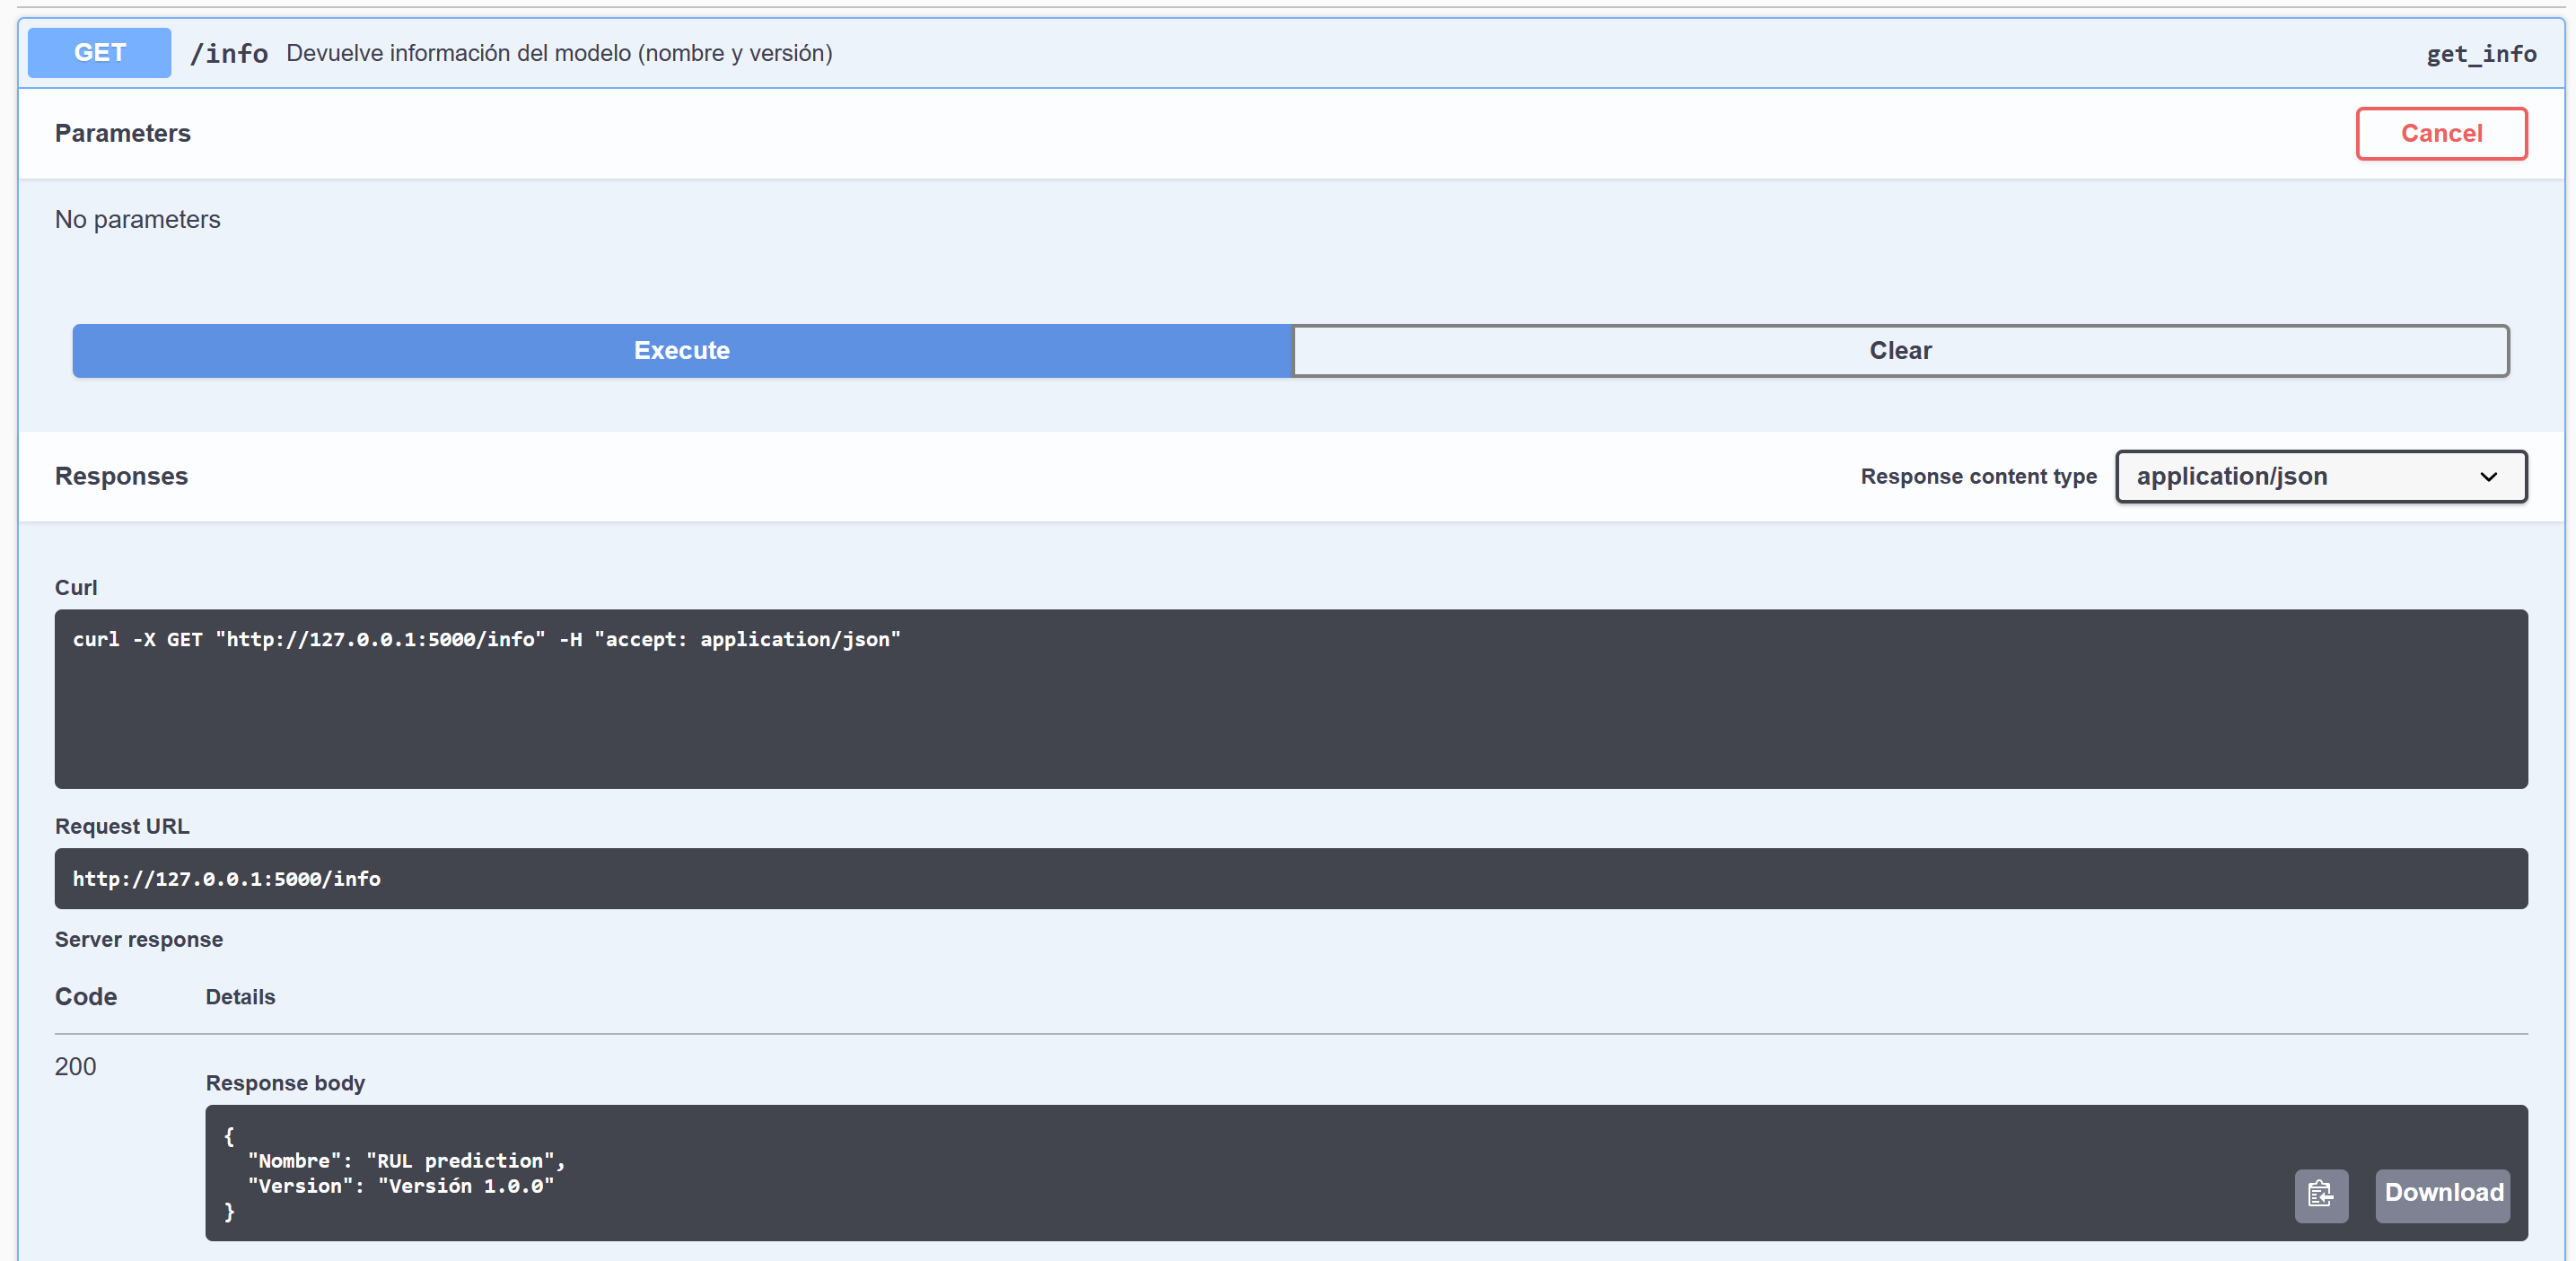

**2. Realizar Predicciones del Motor:**

Mediante el endpoint */predict_file*, los usuarios tienen la capacidad de cargar un archivo CSV que contiene los datos de las diferentes propiedades y condiciones operativas del motor, y con ello obtener una predicción de la vida útil remanente de éste.

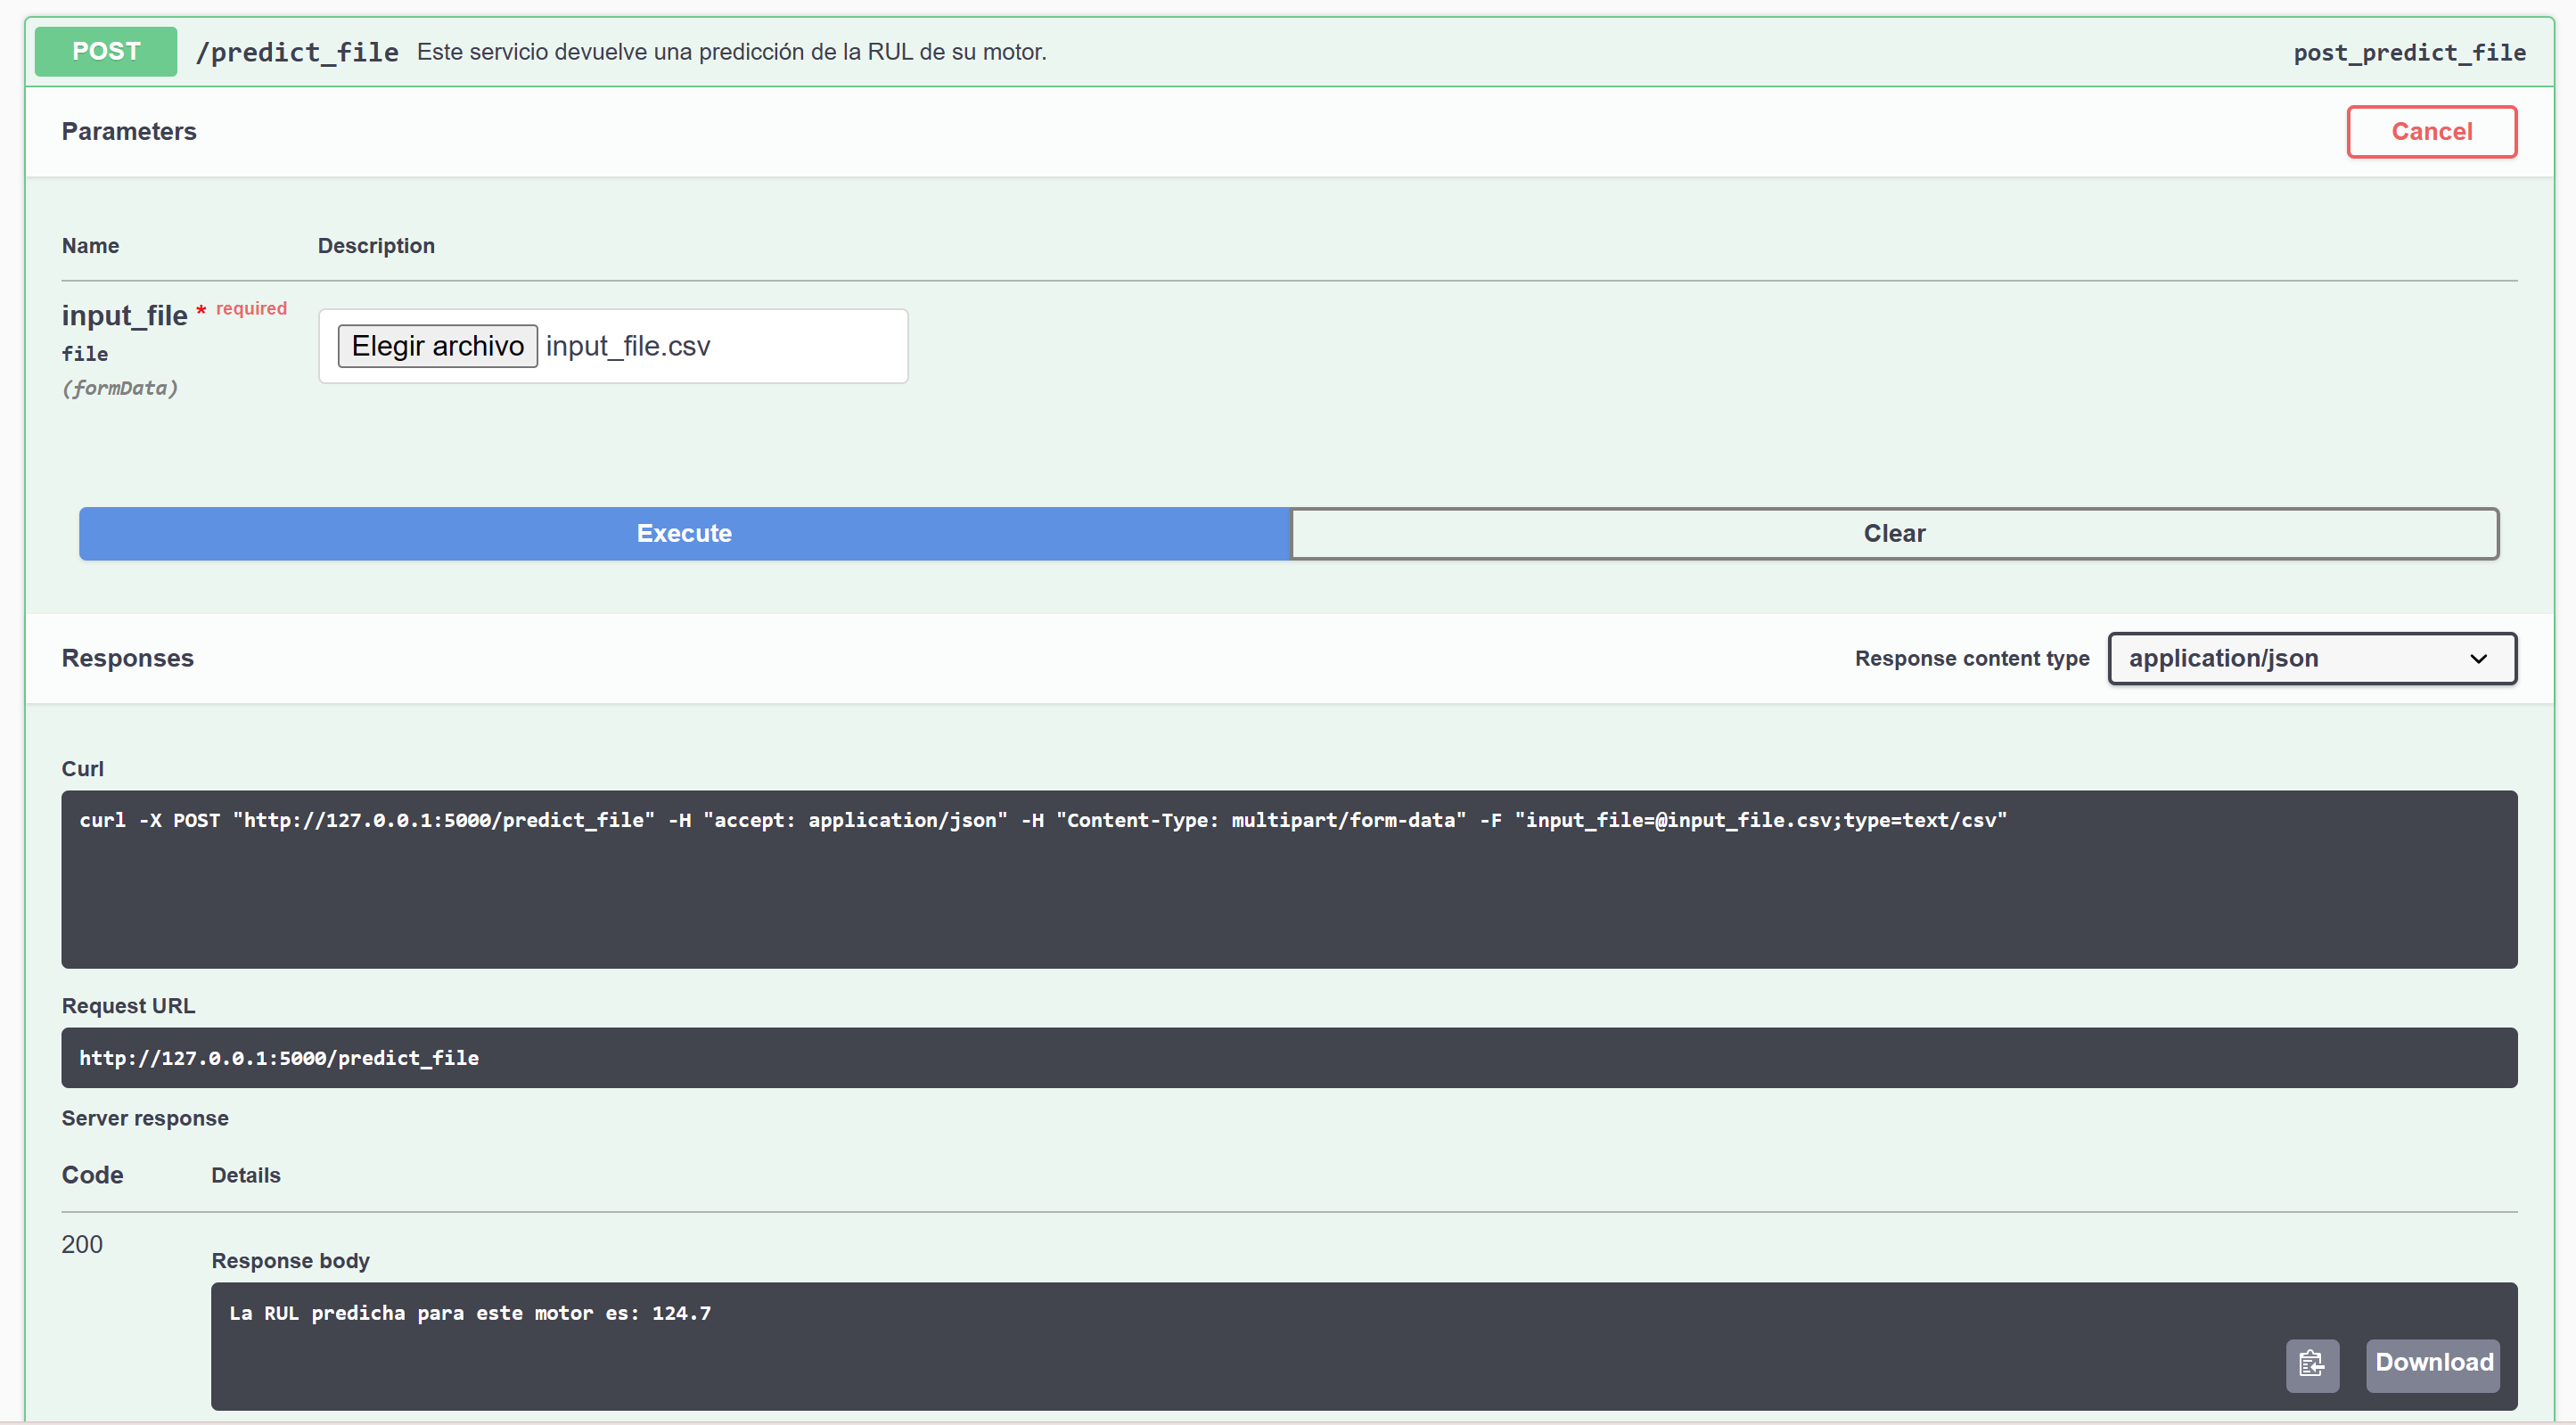

### INPUT FILE 

Los datos que se deben adjuntar serán un archivo CSV con el siguiente esquema: 

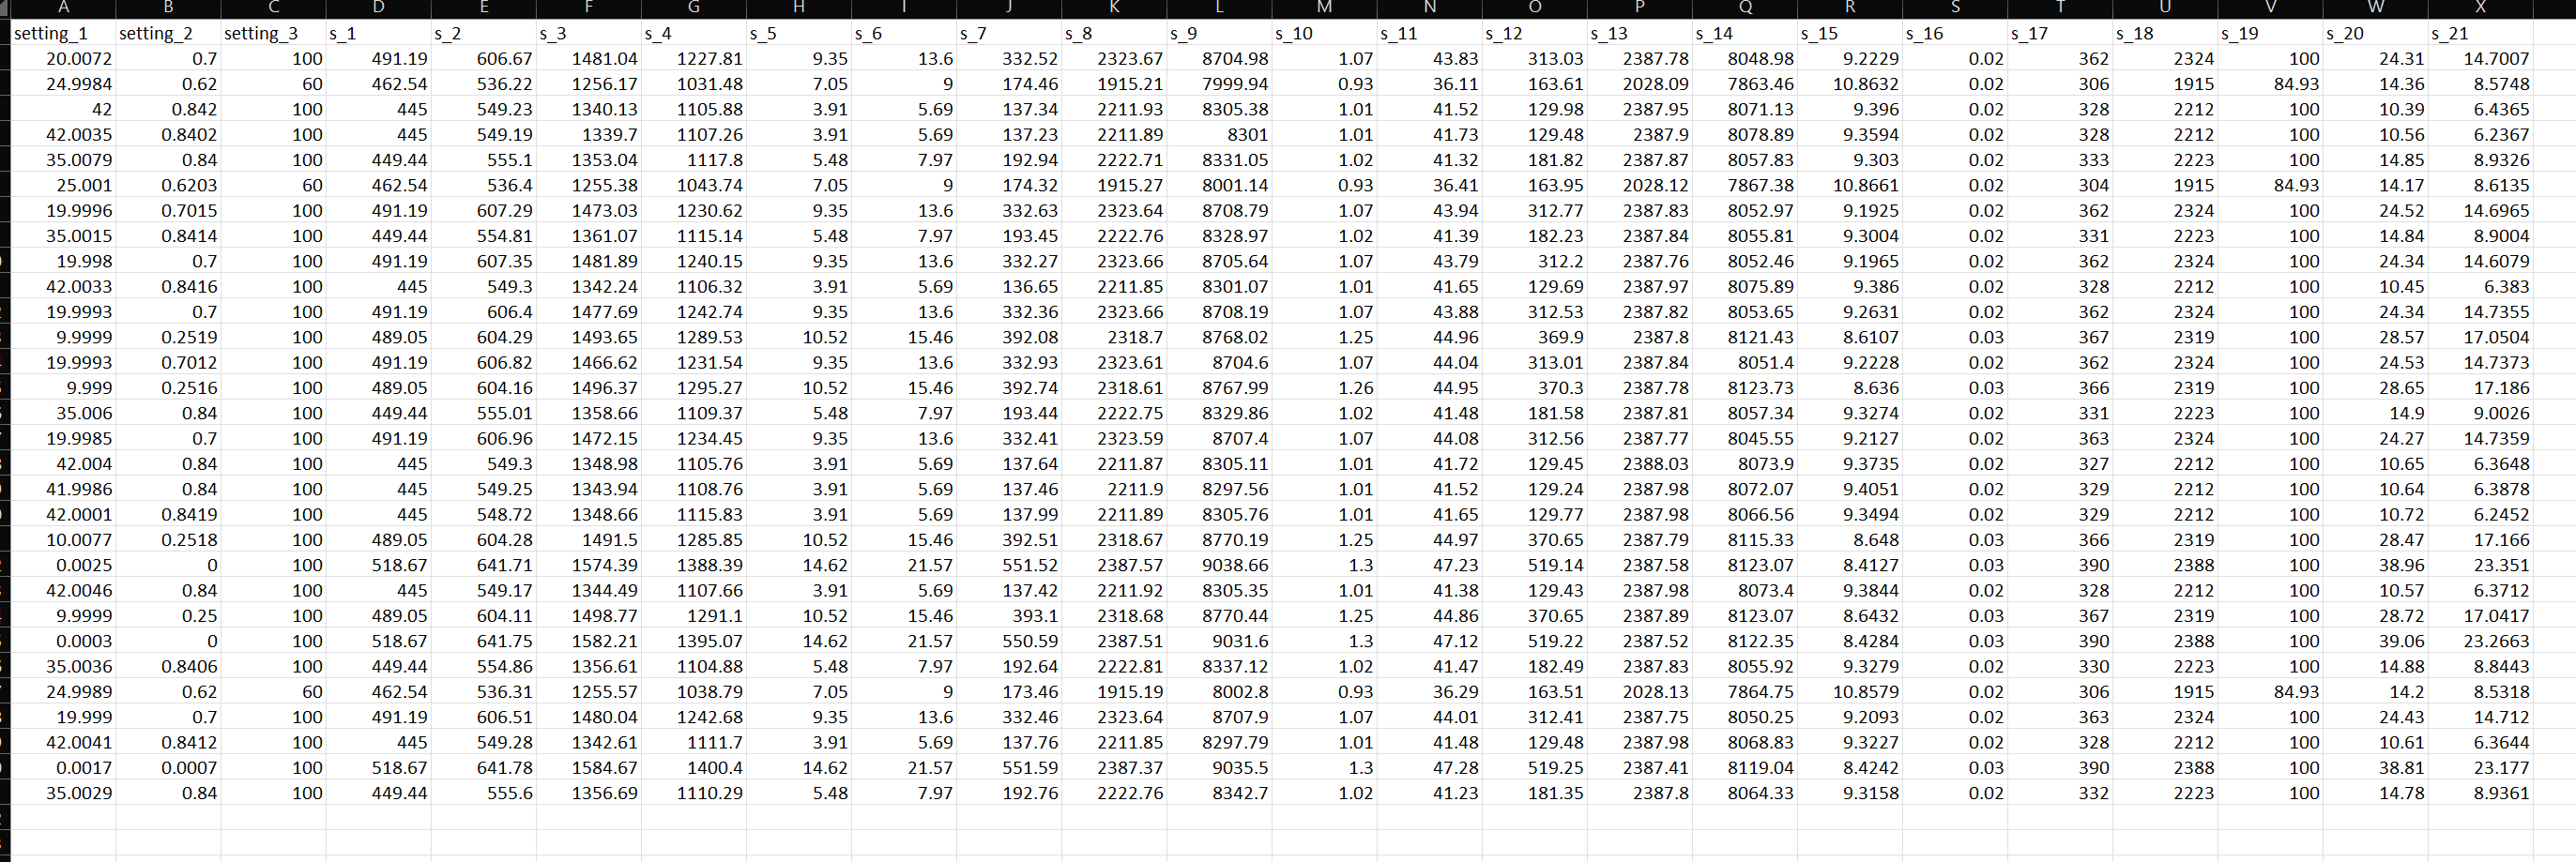

No es necesario que los usuarios eliminen manualmente las variables no usadas en la predicción, ya que la función de *predict_file* se encargará de eliminar aquellas no utilizadas, y de procesar aquellas necesarias para realizar las predicciones. 

In [1]:
from IPython.core.display import HTML, display

style = """
<style>
div.output_area {
    max-height: 500px; 
}

.rendered_html p {
    text-align: justify;
    font-size: 13px;
}

.rendered_html ul li, .rendered_html ol li {
    font-size: 13px;
}

.rendered_html h2#eda {
    background-color: #80B8D1;
    color: white;
    padding: 10px;
    font-size: 18px;
}
</style>
"""

display(HTML(style))